# Standard Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from keras.datasets import mnist

# SETTING HYPERPARAMETERS

In [38]:
batch_size = 100
original_dim = 28 * 28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

# CREATING THE SAMPLING HELPER FUNCTION

In [39]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# CREATING CUSTOM VAE LOSS LAYER

In [40]:
class VAE_LossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean, z_log_var, z_mean):
        xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x, x_decoded_mean, z_log_var, z_mean = inputs
        loss = self.vae_loss(x, x_decoded_mean, z_log_var, z_mean)
        self.add_loss(loss)
        return x_decoded_mean

# CREATING THE ENCODER

In [41]:
# Encoder
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# WRITING THE DECODER

In [43]:
# Decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")

# COMBINING THE MODEL

In [44]:
output_combined = decoder(encoder(x)[2])

# ADD THE VAE LOSS AS A LAYER

In [45]:
vae_loss_layer = VAE_LossLayer()([x, output_combined, z_log_var, z_mean])

# VAE MODEL

In [46]:
vae = Model(x, vae_loss_layer, name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 2), (None, 2), │        201,988 │ input[0][0]            │
│                           │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoding (Dense)          │ (None, 256)            │        200,960 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 784)            │        202,256 │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log-variance (Dense)      │ (None, 2)              │            514 │ encoding[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │            514 │ encoding[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae__loss_layer_6         │ (None, 784)            │              0 │ input[0][0],           │
│ (VAE_LossLayer)           │                        │                │ decoder[0][0],         │
│                           │                        │                │ log-variance[0][0],    │
│                           │                        │                │ mean[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

# COMPILE THE VAE

In [47]:
vae.compile(optimizer='rmsprop')

# LOAD MNIST DATASET

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# TRAIN THE MODEL

In [49]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 223.9882 - val_loss: 172.6862
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 172.5320 - val_loss: 169.0362
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 169.2297 - val_loss: 166.2352
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 166.0894 - val_loss: 163.9558
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 163.8585 - val_loss: 162.2746


# ENCODE THE TEST SET

In [50]:
z_mean_test, _, _ = encoder.predict(x_test, batch_size=batch_size)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# PLOT THE 2D LATENT SPACE

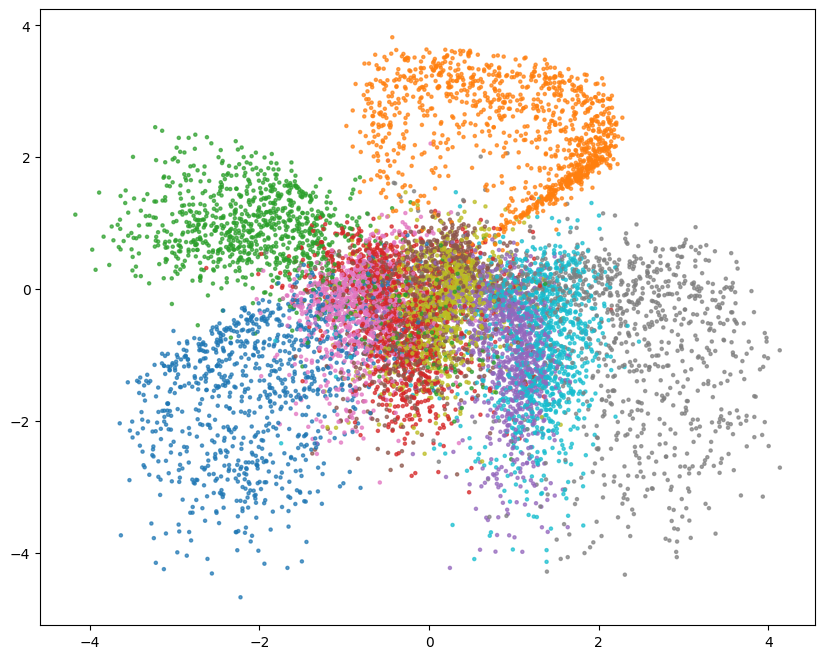

In [51]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test, cmap='tab10', s=5, alpha=0.7)

# CREATE A LEGEND

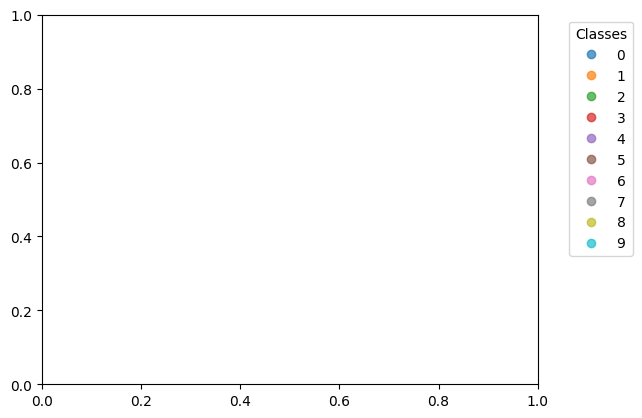

In [52]:
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# ADD LABELS AND TITLE

Text(0.5, 1.0, '2D Projection of Test Set into Latent Space')

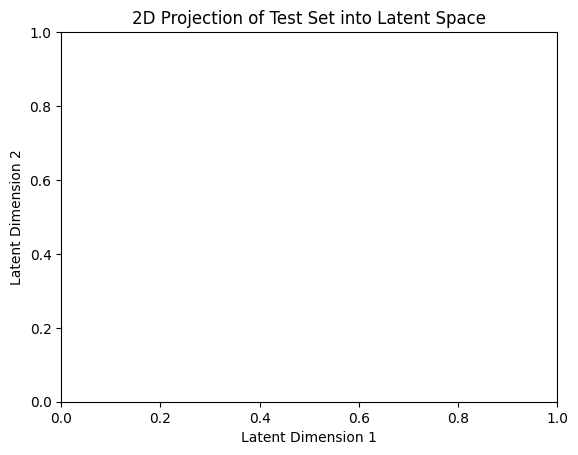

In [53]:
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Projection of Test Set into Latent Space")

# SHOW PLOT

In [55]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# DEFINE GRID PARAMETERS FOR VISUALISATION

In [56]:
n = 20  # Number of points in each dimension of the grid
digit_size = 28  # Size of the MNIST images
figure_size = 10  # Size of the figure

# CREATE A GRID OF LATENT SPACE VALUES

In [57]:
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# CREATE A FIGURE TO PLOT THE GENERATED IMAGES

In [59]:
figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Generate a latent vector
        z_sample = np.array([[xi, yi]])
        # Decode the latent vector into an image
        x_decoded = decoder.predict(z_sample)
        # Rescale the image to the range [0, 1]
        image = np.clip(x_decoded.reshape(digit_size, digit_size), 0, 1)
        # Place the image in the grid
        figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

# Plot the figure

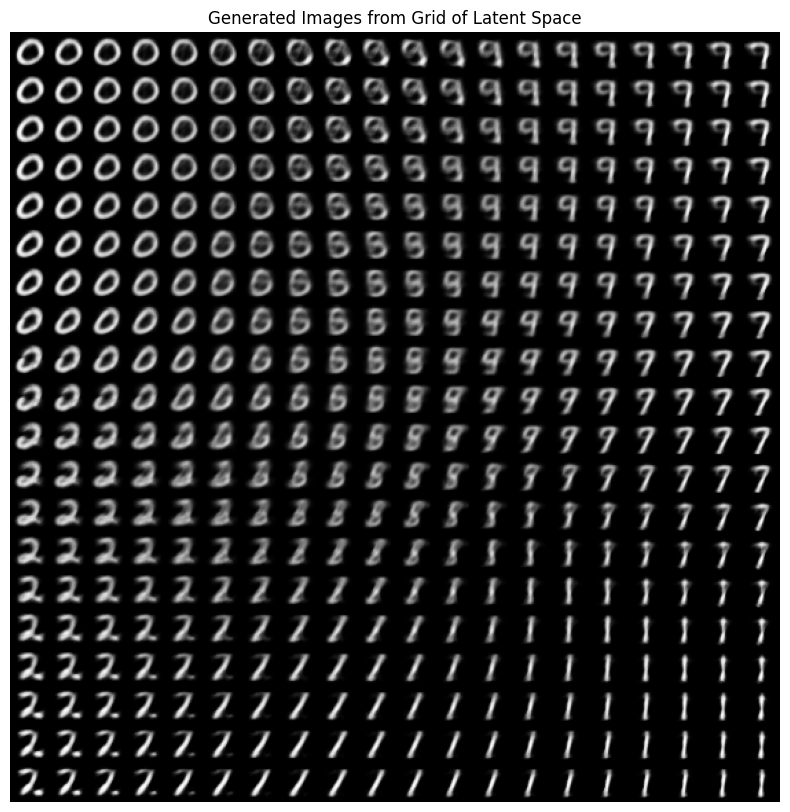

In [60]:
plt.figure(figsize=(figure_size, figure_size))
plt.imshow(figure, cmap='gray')
plt.title("Generated Images from Grid of Latent Space")
plt.axis('off')
plt.show()

# COMPLETE CODE

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 2), (None, 2), │        201,988 │ input[0][0]            │
│                           │ (None, 2)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoding (Dense)          │ (None, 256)            │        200,960 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 784)            │        202,256 │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log-variance (Dense)      │ (None, 2)              │            514 │ encoding[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │            514 │ encoding[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae__loss_layer_7         │ (None, 784)            │              0 │ input[0][0],           │
│ (VAE_LossLayer)           │                        │                │ decoder[0][0],         │
│                           │                        │                │ log-variance[0][0],    │
│                           │                        │                │ mean[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 221.2098 - val_loss: 172.1489
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 171.2134 - val_loss: 167.4647
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 166.6445 - val_loss: 164.7231
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 164.4272 - val_loss: 163.4001
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 163.0214 - val_loss: 162.0076
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


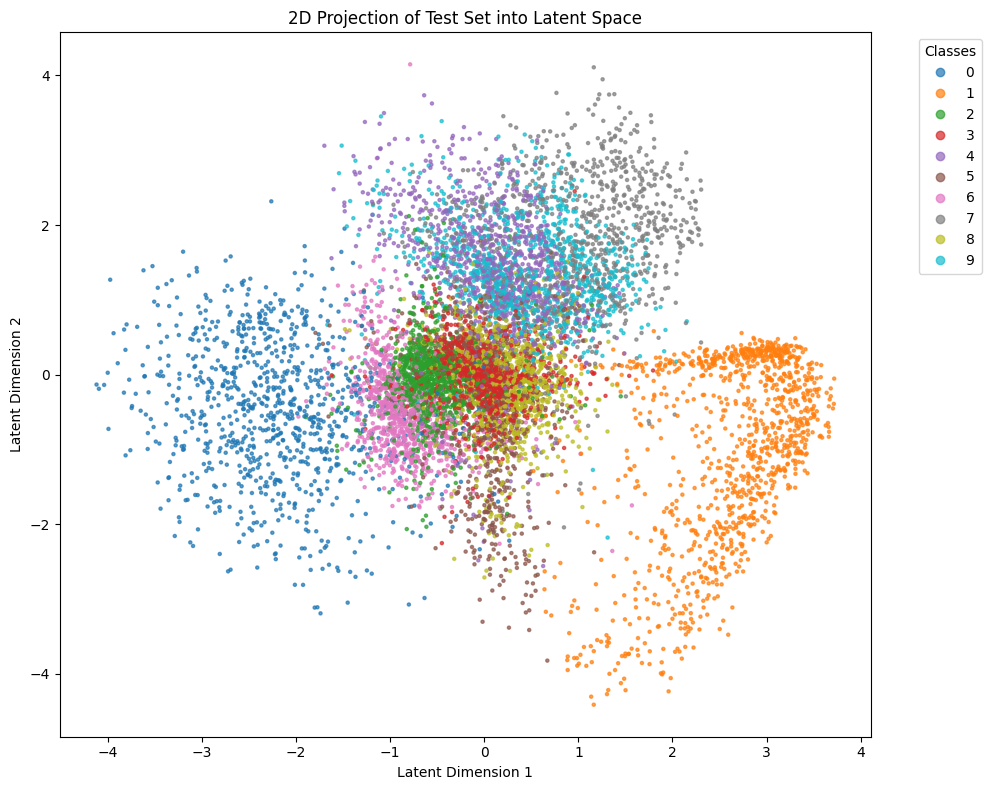

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

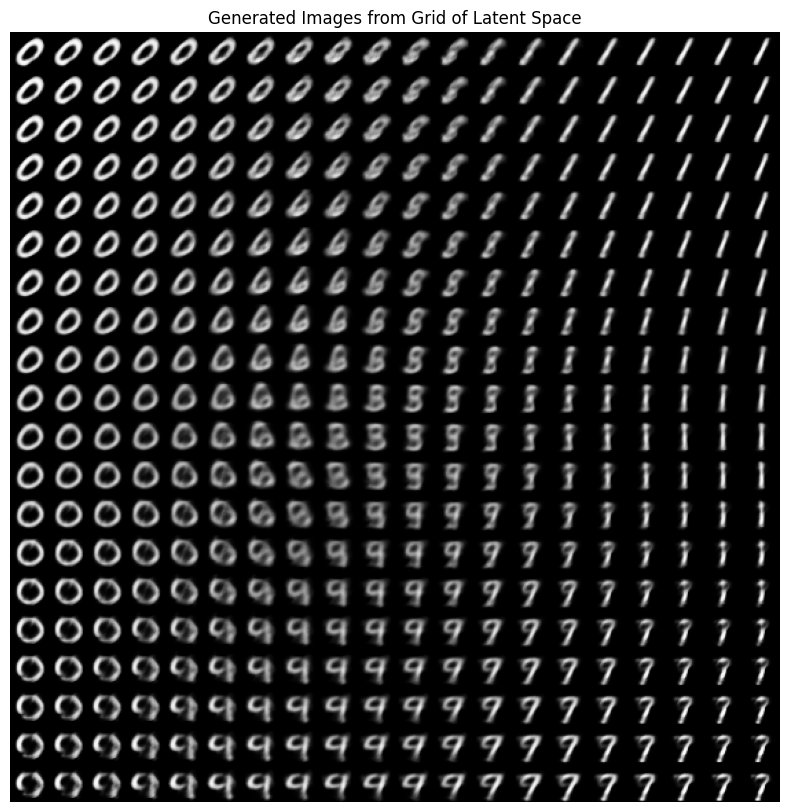

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from keras.datasets import mnist

batch_size = 100
original_dim = 28 * 28
latent_dim = 2
intermediate_dim = 256
nb_epoch = 5
epsilon_std = 1.0

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Custom VAE Loss Layer
class VAE_LossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean, z_log_var, z_mean):
        xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x, x_decoded_mean, z_log_var, z_mean = inputs
        loss = self.vae_loss(x, x_decoded_mean, z_log_var, z_mean)
        self.add_loss(loss)
        return x_decoded_mean

# Encoder
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# Decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")

# Combine the encoder and decoder
output_combined = decoder(encoder(x)[2])

# Add the VAE loss as a layer
vae_loss_layer = VAE_LossLayer()([x, output_combined, z_log_var, z_mean])

# VAE model
vae = Model(x, vae_loss_layer, name="vae")
vae.summary()

# Compile the VAE
vae.compile(optimizer='rmsprop')

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Train the model
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

# Encode the test set
z_mean_test, _, _ = encoder.predict(x_test, batch_size=batch_size)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c=y_test, cmap='tab10', s=5, alpha=0.7)

# Create a legend
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Projection of Test Set into Latent Space")

# Show plot
plt.tight_layout()
plt.show()

# Define grid parameters for visualization
n = 20  # Number of points in each dimension of the grid
digit_size = 28  # Size of the MNIST images
figure_size = 10  # Size of the figure

# Create a grid of latent space values
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

# Create a figure to plot the generated images
figure = np.zeros((digit_size * n, digit_size * n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Generate a latent vector
        z_sample = np.array([[xi, yi]])
        # Decode the latent vector into an image
        x_decoded = decoder.predict(z_sample)
        # Rescale the image to the range [0, 1]
        image = np.clip(x_decoded.reshape(digit_size, digit_size), 0, 1)
        # Place the image in the grid
        figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) * digit_size] = image

# Plot the figure
plt.figure(figsize=(figure_size, figure_size))
plt.imshow(figure, cmap='gray')
plt.title("Generated Images from Grid of Latent Space")
plt.axis('off')
plt.show()
